# SMAI Assignment - 2

## Question 3: Face Recognition using Principal Component Analysis

This question requires you to create a basic facial recognition system using a technique called principal component analysis (PCA)
by projecting the face images on the feature space (face space) which best
represents the variations among distinct faces. The face space is defined as the
“Eigenfaces", which are the eigenvectors of the set of faces.

The goal of implementing this system is to recognize a person's face by comparing it to a pre-existing database of faces, and identifying the closest match.

Link to paper on Eigenfaces: [https://sites.cs.ucsb.edu/~mturk/Papers/mturk-CVPR91.pdf](https://sites.cs.ucsb.edu/~mturk/Papers/mturk-CVPR91.pdf)

The AT&T face dataset contains a set of grayscale face images with dimensions 92x112. The images are organised in 40 directories (one for each subject), which have names of the form sX, where X indicates the subject number (between 1 and 40). In each of these directories, there are ten different images of that subject, which have names of the form Y.pgm, where Y is the image number for that subject (between 1 and 10). These 10 images per person are taken at different times, varying the lighting, facial expressions (open / closed eyes, smiling / not smiling) and facial details (glasses / no glasses). All the images were taken against a dark homogeneous background with the subjects in an upright, frontal position (with tolerance for some side movement). <b>Link:</b> [https://git-disl.github.io/GTDLBench/datasets/att_face_dataset/](https://git-disl.github.io/GTDLBench/datasets/att_face_dataset/)

#### Tasks
1. Load dataset and divide the date into training and test sets.
2. Implement the PCA algorithm from scratch.
3. Implement image reconstruction using the eigen projections and visualise differences for different number of components.
4. Visualise the mean(Eigen face) generated.
5. Given training set, obtain accuracy by attempting a face regonition module and obtaining the accuracy for different number of principal components.

#### Import Libraries

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import cv2
from copy import copy
from tqdm import tqdm

In [54]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [55]:
ls


ATnT/  old/  Q3.ipynb


In [56]:
cd /content/drive/MyDrive/Colab Notebooks/rollnumber_A2/rollnumber_A2_Q3

/content/drive/MyDrive/Colab Notebooks/rollnumber_A2/rollnumber_A2_Q3


In [57]:
ls


ATnT/  old/  Q3.ipynb


#### Import Dataset
Assign labels for the images based on the subdirectories to obtain X(images array) and y (labels).

Ensure that the test data contains atleast one image from each category.

In [58]:
ls

ATnT/  old/  Q3.ipynb


In [59]:
# iterate through all folders, load each image

trainAmt = 0.9
allFaces = []
labels = []

for i in range(1,41):
    for j in range(1,11):
        imgPath = os.path.join("ATnT", "s" + str(i), str(j) + ".pgm")
        img = cv2.imread(imgPath, -1)

        allFaces.append(img)
        labels.append(i)

# shuffle
randomOrder = np.random.permutation(len(labels))
allFaces = np.array(allFaces)[randomOrder]
labels = np.array(labels)[randomOrder]

# split
trainFaces = allFaces[:int(trainAmt*len(allFaces))]
trainLabels = labels[:int(trainAmt*len(allFaces))]

testFaces = allFaces[int(trainAmt*len(allFaces)): ]
testLabels = labels[int(trainAmt*len(allFaces)): ]

# 112x92 (= 10304) grayscale images,  360 in train, 40 in test
print(trainFaces.shape, trainLabels.shape)

(360, 112, 92) (360,)


#### Implement PCA Algorithm.

Explain your steps with comments and write a brief explanation of the method.

In [60]:
def principalComponentAnalysis(X, numComponents):
    """
    Implement pca in the following function by taking the following arguements:
    1. X(images array)
    2. number of components
    The function must return the eigen vectors (principal components) also termed "Eigen faces"
    """

    # Center the data
    mean_face = np.mean(X, axis=0)
    centered_data = X - mean_face

    # Compute covariance matrix
    cov_matrix = np.cov(centered_data, rowvar=False)

    # Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    k=eigenvalues

    # Sort eigenvalues and corresponding eigenvectors
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]

    # Select the top 'numComponents' eigenvectors
    principal_components = eigenvectors[:, :numComponents]

    return principal_components,k

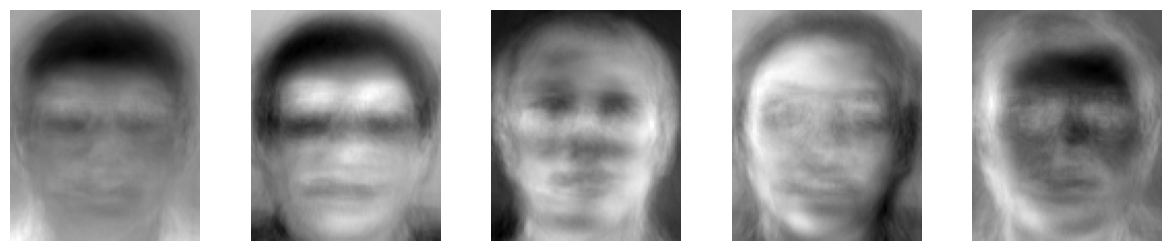

In [52]:
# plot the eigen faces
%matplotlib inline
def project_to_eigenfaces(X, eigenfaces):
    """
    Projects the data onto the eigenfaces.
    """
    return np.dot(X, eigenfaces)

# Use your existing function to obtain eigenfaces
num_components = 25  # You can adjust this value
eigenfaces,k = principalComponentAnalysis(trainFaces.reshape((trainFaces.shape[0], -1)), num_components)

# Visualize the eigenfaces
fig, axes = plt.subplots(1, 5, figsize=(15, 3))  # Adjust the number of subplots accordingly
for i, ax in enumerate(axes.flatten()):
    ax.imshow(eigenfaces[:, i].reshape(trainFaces[0].shape), cmap='gray')
    ax.axis('off')


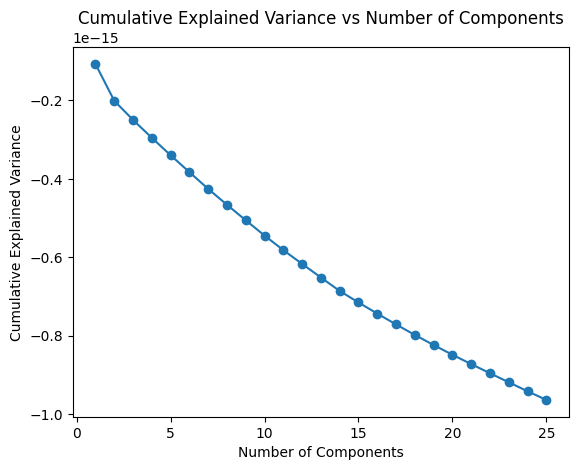

In [61]:
def calculate_cumulative_variance(eigenvalues, num_components):
    total_variance = np.sum(eigenvalues)
    explained_variance = np.cumsum(eigenvalues) / total_variance
    return explained_variance[:num_components]

# Assuming you have already computed eigenvalues in your PCA function
# num_components is the number of components you are considering
explained_variance = calculate_cumulative_variance(k, num_components)

# Plot the cumulative explained variance
plt.plot(range(1, num_components + 1), explained_variance, marker='o')
plt.title('Cumulative Explained Variance vs Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()


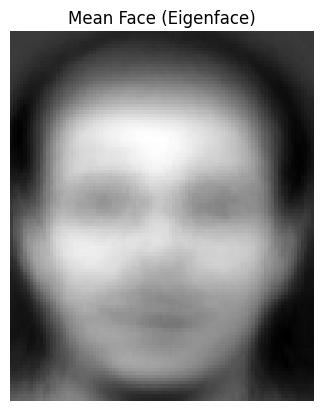

In [62]:
# Compute the mean face
mean_face = np.mean(trainFaces.reshape((trainFaces.shape[0], -1)), axis=0)

# Visualize the mean face
plt.imshow(mean_face.reshape(trainFaces[0].shape), cmap='gray')
plt.title('Mean Face (Eigenface)')
plt.axis('off')
plt.show()



Explain your steps with comments and write a brief explanation of the method.

In [64]:
def imageReconstruction(testFace, eigenFaces, meanFace):
    """
    Helper function to reconstruct images
    """
    # Flatten the input face
    testFace_flatten = testFace.reshape(-1)

    # Project the test face onto the eigenfaces
    eigen_projections = np.dot(testFace_flatten - meanFace, eigenFaces)

    # Reconstruct the face using eigenfaces
    reconstructed_face_flatten = np.dot(eigen_projections, eigenFaces.T) + meanFace

    # Reshape the reconstructed face to its original shape
    reconstructed_face = reconstructed_face_flatten.reshape(testFace.shape)

    return reconstructed_face




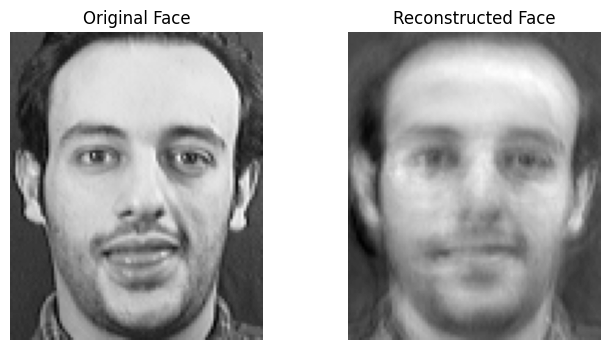

In [65]:
# plot recontructions here
%matplotlib inline

# Choose an image to reconstruct (you can change this index)
image_index = 1
test_face = testFaces[image_index]

# Use the imageReconstruction function
reconstructed_face = imageReconstruction(test_face, eigenfaces, mean_face)

# Plot the original and reconstructed faces
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(test_face, cmap='gray')
plt.title('Original Face')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(reconstructed_face, cmap='gray')
plt.title('Reconstructed Face')
plt.axis('off')

plt.show()

#### Visualisation
Visualise the results for different number of factors(pc = 5, 10, 50, 100, etc.)

**Note:** Ensure that the images are labelled appropriately.

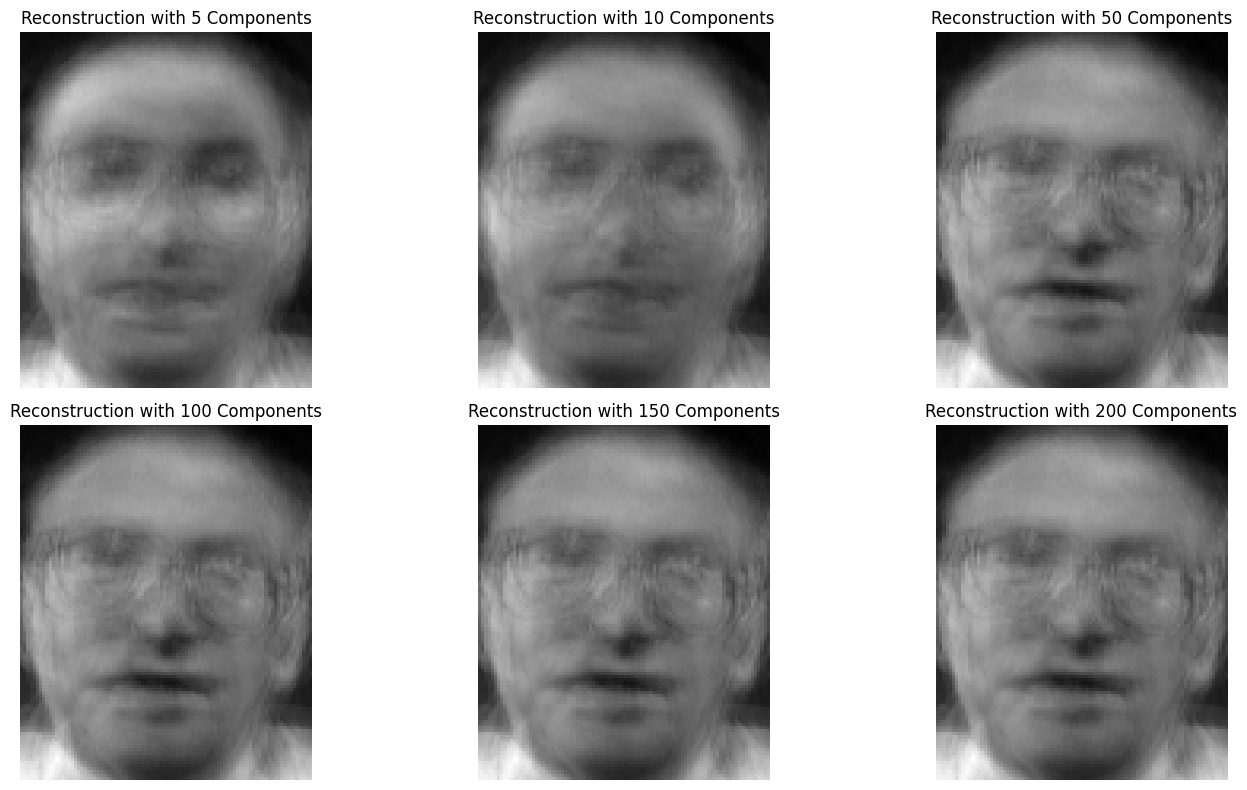

In [66]:
%matplotlib inline

def displayNfactors(testFaces, eigenfaces, meanFace, num_components_list):
    """
    Visualize the reconstruction results for different numbers of principal components.
    """
    num_faces = len(testFaces)

    plt.figure(figsize=(15, 8))

    for i, num_components in enumerate(num_components_list, 1):
        plt.subplot(2, len(num_components_list)//2, i)
        plt.title(f'Reconstruction with {num_components} Components')

        for j in range(num_faces):
            reconstructed_face = imageReconstruction(testFaces[j], eigenfaces[:, :num_components], meanFace)

            plt.imshow(reconstructed_face, cmap='gray')
            plt.axis('off')

            if j == 0:
                plt.title(f'Reconstruction with {num_components} Components')

    plt.tight_layout()
    plt.show()

# Specify the list of numbers of principal components
num_components_list = [5, 10, 50, 100,150,200]  # Add more as needed

# Call the function to display reconstruction results
displayNfactors(testFaces, eigenfaces, mean_face, num_components_list)


#### Implement face recognition module based on the norm
Explain your steps with comments and write a brief explanation of the method.

*   Test the module and report accuracies based on the number of components taken for a range of value and plot them.
*   Also plot the mean square error vs the number of eigenvectors taken and report your observations.
*   For further empirical analysis, plot the semi-log variant of the error plot obtained above.

In [67]:
def getClass(test_face, eigenfaces, mean_face, X_train, y_train):
    """
    Face recognition module based on the L2 norm (Euclidean distance).

    Arguments:
    1. test_face: Test image
    2. eigenfaces: Eigenvectors
    3. mean_face: Mean Eigen Face
    4. X_train: Training set images
    5. y_train: Training set labels

    Returns:
    1. image with smallest error (nearest neighbor)
    2. error value (L2 norm)
    3. prediction class
    """

    # Project the test face onto the eigenfaces
    test_projection = np.dot(test_face.flatten() - mean_face, eigenfaces)

    # Project the training set onto the eigenfaces
    train_projections = np.dot(X_train.reshape((X_train.shape[0], -1)) - mean_face, eigenfaces)

    # Calculate the Euclidean distances (L2 norm) between test_projection and each training projection
    distances = np.linalg.norm(train_projections - test_projection, axis=1)

    # Find the index of the nearest neighbor
    nearest_neighbor_index = np.argmin(distances)

    # Retrieve the corresponding training image, label, and distance
    nearest_neighbor_image = X_train[nearest_neighbor_index]
    nearest_neighbor_label = y_train[nearest_neighbor_index]
    min_distance = distances[nearest_neighbor_index]

    return nearest_neighbor_image, min_distance, nearest_neighbor_label

# Test the face recognition module and report accuracies
def testFaceRecognition(X_test, y_test, eigenfaces, mean_face, X_train, y_train, num_components_list):
    accuracies = []
    mse_values = []

    for num_components in num_components_list:
        # Project the training set onto the specified number of eigenfaces
        train_projections = np.dot(X_train.reshape((X_train.shape[0], -1)) - mean_face, eigenfaces[:, :num_components])

        correct_predictions = 0
        mse_total = 0

        for i in range(len(X_test)):
            # Get the nearest neighbor using the L2 norm
            nearest_neighbor_image, min_distance, predicted_label = getClass(X_test[i], eigenfaces[:, :num_components], mean_face, X_train, y_train)

            # Calculate mean square error (MSE)
            mse = np.mean((X_test[i].flatten() - nearest_neighbor_image.flatten()) ** 2)
            mse_total += mse

            # Check if the prediction is correct
            if predicted_label == y_test[i]:
                correct_predictions += 1

        accuracy = correct_predictions / len(X_test)
        mse_values.append(mse_total / len(X_test))
        accuracies.append(accuracy)

    return accuracies, mse_values





[link text](https://)Iterate through all the images in the test data and test the accuracy by taking different number of components

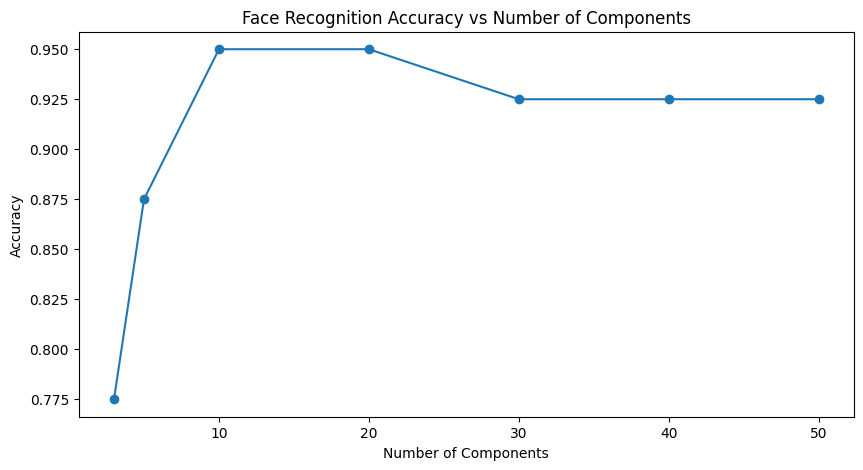

In [68]:
# Specify the list of numbers of principal components to test
num_components_list = [3, 5, 10, 20, 30, 40, 50]  # Add more as needed

# Test the face recognition module
accuracies, mse_values = testFaceRecognition(testFaces, testLabels, eigenfaces, mean_face, trainFaces, trainLabels, num_components_list)

# Plot accuracies
plt.figure(figsize=(10, 5))
plt.plot(num_components_list, accuracies, marker='o')
plt.title('Face Recognition Accuracy vs Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Accuracy')
plt.show()


**Observations:**

- **Effect of Components on Accuracy:**
  - Initially, a sharp rise in accuracy with an increasing number of components.
  - This trend continues up to around 10 components.
  - Beyond 10 components, the accuracy plateaus, showing diminishing returns.

- **Accuracy Plateau:**
  - Adding more components beyond 10 does not result in a significant improvement in recognition accuracy.
  - The highest accuracy achieved is approximately 0.95.

**Implications:**
- The recognition model reaches a saturation point where further complexity (more components) doesn't yield substantial accuracy gains.
- Careful consideration needed when choosing the number of components to balance model complexity and performance.


*Plot* Number of eigenvectors vs Mean Square Error

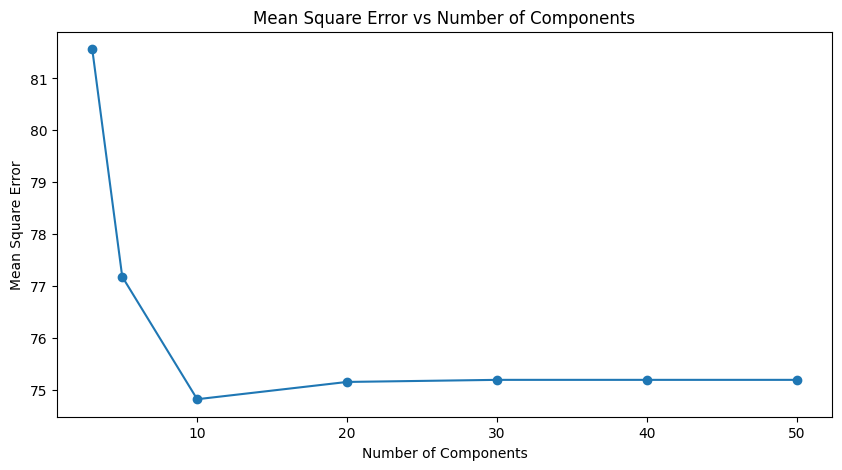

In [69]:
# your code here

# Plot mean square error
plt.figure(figsize=(10, 5))
plt.plot(num_components_list, mse_values, marker='o')
plt.title('Mean Square Error vs Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Mean Square Error')
plt.show()



**Observations:**

- **Effect of Components on Mean Square Error:**
  - Sharp decrease in mean square error with an increasing number of components initially.
  - The error reaches its minimum point around 10 components.
  - Beyond 10 components, the error remains relatively stable with no significant improvement.

**Implications:**
- The mean square error experiences diminishing returns beyond a certain number of components.
- Around 10 components, the model achieves its optimal performance in minimizing the error.


Plot Number of eigenvectors vs Logarithmic Mean Square Error

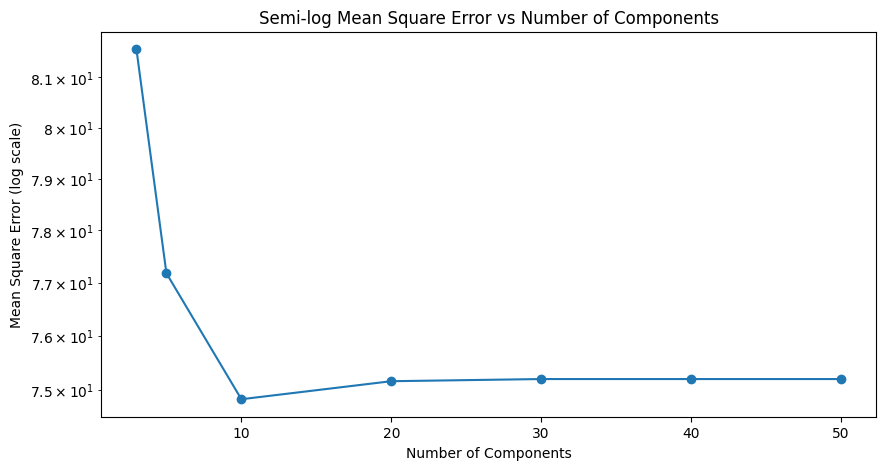

In [70]:
# your code here

# Plot semi-log variant of the error plot
plt.figure(figsize=(10, 5))
plt.semilogy(num_components_list, mse_values, marker='o')
plt.title('Semi-log Mean Square Error vs Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Mean Square Error (log scale)')
plt.show()

**Observations:**

- **Effect of Components on Mean Square Error:**
  - Sharp decrease in mean square error with an increasing number of components initially.
  - The error reaches its minimum point around 10 components.
  - Beyond 10 components, the error remains relatively stable without significant improvement.

**Implications:**
- The mean square error experiences diminishing returns beyond a certain number of components.
- Around 10 components, the model achieves its optimal performance in minimizing the error.
